In [1]:
%load_ext autotime

# Examine Target

This notebook look at some of the properties for a specific target as pulled from the sources listed generated in the [Source Detection](PIAA-Source-Detection-And-Filtering.ipynb) notebook. 

Note that this step is not necessary for the processing of an observation sequence as a whole but instead serves to highlight some of the issues with processing the images in a traditional fashion and thus helps motivate our unique algorithm.

In [2]:
import os

from matplotlib import cm
from matplotlib import pyplot as plt
plt.style.use('bmh')

import numpy as np
import pandas as pd
from collections import defaultdict

from tqdm import tqdm_notebook as tqdm

from piaa.utils import pipeline
from piaa.utils import helpers
from piaa.utils import plot
from piaa.utils.postgres import get_cursor
from piaa.utils import noise

from pocs.utils.images import fits as fits_utils
from pocs.utils.google.storage import PanStorage

from astropy.io import fits
from astropy.stats import sigma_clip, sigma_clipped_stats
from astropy import units as u

tess_cursor = get_cursor(port=5433, db_name='v6', db_user='postgres')

styles = plot.get_labelled_style_cycler(cmap='Paired')

time: 3.2 s


## Specify Target

Here we look up the target HD189733 by the 2MASS ID.

In [15]:
# picid = 435715608
# picid = 287933433
# picid = 287511722
# picid = 393243342
# picid = 343362027 # Hot pixel?
# picid = 11133916  # Same mag as HD189733
# picid = 86234511
# picid = helpers.get_star_info(twomass_id='20005694+2250490', cursor=tess_cursor).id
picid = 11135315

star_info = helpers.get_star_info(picid=picid, cursor=tess_cursor)

time: 48.7 ms


In [4]:
twomass = '20004370+2242391'

star_info = helpers.get_star_info(twomass_id=twomass, cursor=tess_cursor)
picid = star_info.id  # HD 189733

time: 46.5 ms


In [16]:
print(f'PICID: {picid}')

PICID: 11135315
time: 1.02 ms


#### Observation sources

We use the previously detected and filtered sources to examine our target. See the [Source-Detection](Source-Detection-And-Filtering.ipynb) for details.

In [6]:
base_dir = '/var/panoptes/images/fields/PAN012/358d0f/20180822T035809/'
# base_dir = '/var/panoptes/images/fields/PAN001/Hd189733/14d3bd/20180913T085704/'
source_filename = os.path.join(base_dir, f'point-sources-filtered.csv')

sources = pipeline.lookup_sources_for_observation(filename=source_filename).set_index(['picid'], append=True)

time: 949 ms


For our target table we want to compare the flux as calculated from `sextractor` (which has no knowledge of the RGB array) with that pulled from a custom stamp.  `sextractor` uses a 6-pixel circular aperture  centered around the calculated centroid (the `x` and `y` values in our `sources` table) while our custom stamps will use an aperture that is sliced according to our rule of having a fixed pixel pattern. Here we use a 6-pixel aperture on our stamps for direct comparison with `sextractor` but the size can be vary.

In [7]:
camera_bias = 2048 * u.adu
stamp_size = 6 * u.pixel
num_pixels = (stamp_size**2).value

readout_noise = 10.5 * u.electron / u.pixel
gain = 1.5 * (u.electron / u.adu)
qe = 0.43

focal_length = 85 * u.mm
fstop = 1.4

aperture_area = focal_length / fstop
aperture_area = (np.pi * (aperture_area / 2)**2).to(u.m * u.m)

time: 2.67 ms


In [8]:
num_sources = len(sources.index.levels[1])

time: 743 µs


In [9]:
counts = list()

i = 0
for pid, target_table in tqdm(sources.groupby('picid'), total=num_sources):
    i += 1
#     if i > 10:
#         break
    psc = pd.read_csv(os.path.join(base_dir, 'stamps', f'{pid}.csv'), parse_dates=True).set_index(['obs_time', 'picid'])
    
    for idx, row in psc.iterrows():
        date_obs= idx[0]
        stamp = row.values.reshape(10, 10) - camera_bias.value
        
        row_info = dict(date_obs=date_obs, picid=pid)

        # Store the overall flux count
        flux_stamp = stamp.sum()
        row_info['stamp'] = flux_stamp
        
        stamp_mean, stamp_med, stamp_std = sigma_clipped_stats(stamp)
        row_info['stamp_back_mean'] = stamp_mean
        row_info['stamp_back_std'] = stamp_std
        
        color_data = helpers.get_rgb_data(stamp, force_new=True)

        # Calculate some properties for each channel
        for color, data in zip('rgb', color_data):
            # Total sum of stamp
            stamp_sum = int(data.sum())
            
            # Background noise
            back_mean, back_med, back_std = sigma_clipped_stats(data)
            row_info[f'{color}_back_mean'] = back_mean
            row_info[f'{color}_back_std'] = back_std
            
            stamp_sum = (data - back_mean).sum()
            
            if stamp_sum <= 0:
#                 print(f'Negative stamp: {pid} {color} {date_obs} {stamp_sum}')
                continue
                
            row_info[f'{color}_raw'] = data.sum()
            row_info[f'{color}_stamp'] = stamp_sum

            # Photon noise
            count_noise = int(np.sqrt(stamp_sum))
            row_info[f'{color}_stamp_noise'] = count_noise

            # Readout noise
            readout = ((readout_noise / gain) * (data.count() * u.pixel)).value
            row_info[f'{color}_readout_noise'] = readout
            
        counts.append(row_info)

df1 = pd.DataFrame(counts).set_index(['date_obs'])
df1.index = pd.to_datetime(df1.index)
df1.to_csv(os.path.join(base_dir, f'point-sources-noise.csv'))


time: 54min 25s


In [17]:
target_noise = df1.loc[df1.picid == picid]

time: 4.19 ms


In [20]:
target_noise.head()

,b_back_mean,b_back_std,b_readout_noise,b_stamp,b_stamp_noise,g_back_mean,g_back_std,g_readout_noise,g_stamp,g_stamp_noise,picid,r_back_mean,r_back_std,r_readout_noise,r_stamp,r_stamp_noise,stamp,stamp_back_mean,stamp_back_std
date_obs,,,,,,,,,,,,,,,,,,,
2018-08-22 04:02:02,812.714286,66.586244,175.0,2858.142857,53.0,1547.565217,147.614753,350.0,3366.739130,58.0,11135315,978.409091,73.331538,175.0,1095.772727,33.0,129477.0,1278.666667,393.491622
2018-08-22 04:07:23,800.857143,57.501375,175.0,2191.571429,46.0,1563.306122,196.570723,350.0,1632.693878,40.0,11135315,972.250000,85.720111,175.0,721.750000,26.0,127039.0,1250.939394,370.309230
2018-08-22 04:09:11,780.210526,39.655860,175.0,2815.736842,53.0,1496.930233,109.861942,350.0,4612.488372,67.0,11135315,968.375000,88.216973,175.0,663.625000,25.0,126653.0,1248.161616,371.373909
2018-08-22 04:10:58,785.250000,33.901143,175.0,2792.750000,52.0,1528.234043,169.572832,350.0,2721.297872,52.0,11135315,968.458333,81.149029,175.0,679.541667,26.0,126448.0,1246.494949,372.849128
2018-08-22 04:12:46,798.272727,72.328281,175.0,2442.181818,49.0,1474.930233,105.031201,350.0,4745.488372,68.0,11135315,963.173913,83.431645,175.0,921.652174,30.0,125892.0,1245.383838,385.223448


time: 29.9 ms


In [18]:
g_err = np.sqrt(target_noise.g_back_std**2 + target_noise.g_readout_noise**2 + target_noise.g_stamp_noise**2)

time: 2.66 ms


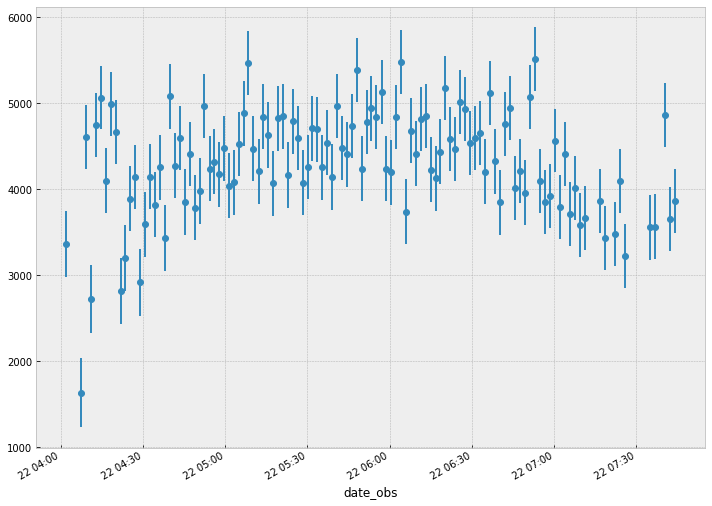

time: 538 ms


In [19]:
plt.figure(figsize=(12, 9))
target_noise.g_stamp.plot(ls='', marker='o', yerr=g_err)